In [173]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [174]:
# extracción de los datos
datos, info = tfds.load("fashion_mnist", as_supervised=True, with_info=True)

In [175]:
# separando las imagenes de entrenamiento y validación con su respectiva etiqueta
train_images, test_images = datos["train"], datos["test"]

In [176]:
# normalizando los datos de 0-255 a 0-1

def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255
    return imagenes, etiquetas

train_images_nor = train_images.map(normalizar)
test_images_nor = test_images.map(normalizar)

In [177]:
# nombre de la etiquetas (variable dependiente)
labels_names = info.features["label"].names

2025-08-22 18:59:55.331754: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


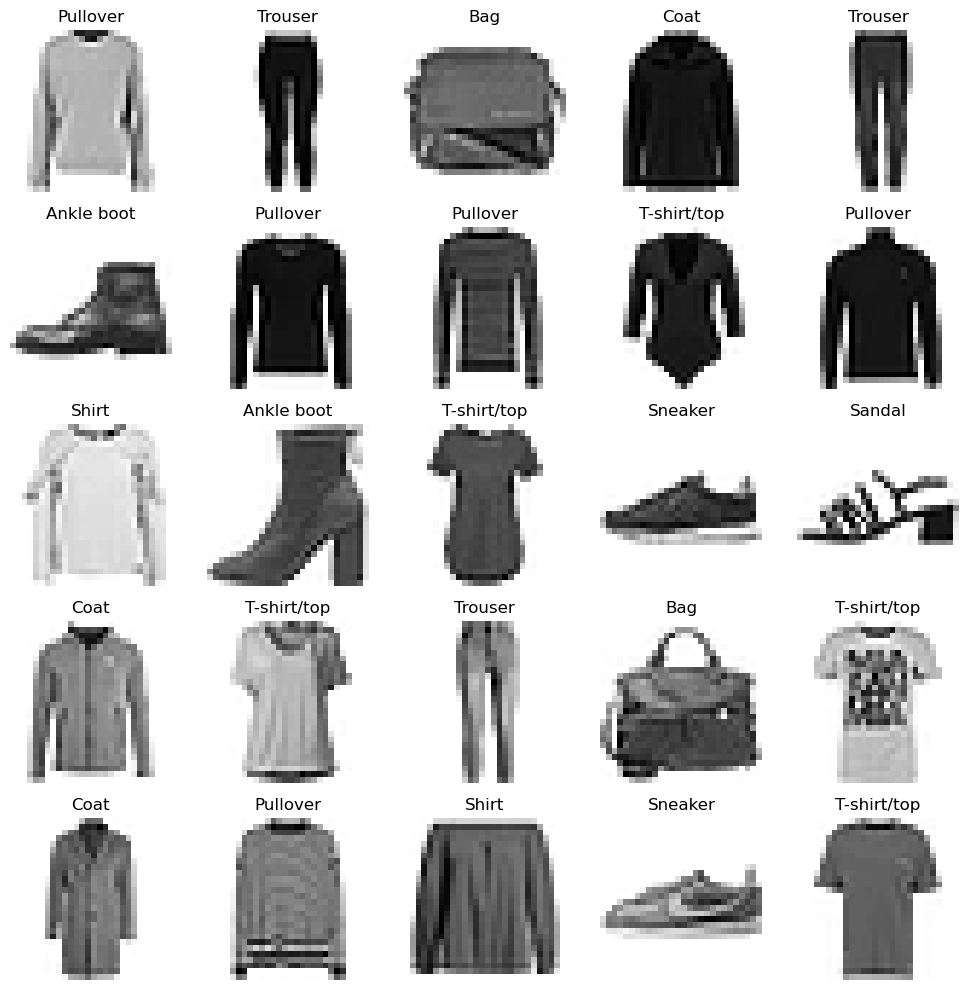

In [178]:
# graficando algunas imagenes
fig, ax = plt.subplots(5, 5, figsize=(10,10))
ax = ax.flat
for i, (imagen, etiqueta) in enumerate(train_images_nor.take(25)):
    imagen = imagen.numpy()
    ax[i].imshow(imagen, cmap=plt.cm.binary)
    ax[i].set_title(labels_names[etiqueta])
    ax[i].axis("off")
plt.tight_layout()
plt.show()

In [179]:
# cantidad de datos para entrenamiento y prueba
num_train_imgs = info.splits["train"].num_examples
num_test_imgs = info.splits["test"].num_examples
num_train_imgs, num_test_imgs

(60000, 10000)

In [180]:
# transformando los datos de entrenamiento en arrays de numpy
images_train, labels_train = zip(*map(
    lambda x: (x[0].numpy(), x[1].numpy()), train_images_nor))

# trasformando los datos de prueba en arrays de numpy
images_test, labels_test = zip(*map(
    lambda x: (x[0].numpy(), x[1].numpy()), test_images_nor))

In [181]:
images_train= np.array(images_train)
labels_train = np.array(labels_train)

images_test = np.array(images_test)
labels_test = np.array(labels_test)

In [182]:
# transformación de las etiquetas en un formato one-hot encoding
# para su uso en la red neuronal convolucional

from tensorflow.keras.utils import to_categorical #type: ignore

labels_train_oh = to_categorical(labels_train, num_classes=10)
labels_test_oh = to_categorical(labels_test, num_classes=10)

## Red neuronal convolucional (cnn)

In [183]:
images_train[0].shape

(28, 28, 1)

In [184]:
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import  Input, Conv2D, BatchNormalization, Dense, Dropout, Flatten, MaxPooling2D #type:ignore

model = Sequential()
model.add(Input((28,28,1)))
model.add(Conv2D(32, kernel_size=(3,3), padding="same", kernel_regularizer="l2", activation="relu"))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), padding="same", kernel_regularizer="l2", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), padding="same", kernel_regularizer="l2", activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

### Descripción de la última capa:

* **Número de neuronas:** Tiene 10 neuronas, lo que indica que el modelo está diseñado para clasificar las imágenes en 10 categorías diferentes.

* **Activación softmax:** La función de activación softmax convierte las salidas de las neuronas en probabilidades, sumando 1. Cada neurona representa la probabilidad de que la imagen pertenezca a una de las 10 clases.

In [185]:
# generando la aumentación de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore

datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True)

In [186]:
# compilando el modelo
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping #type:ignore

early_stopping_callback = EarlyStopping(monitor="val_loss", 
                                        min_delta=0.001,
                                        patience=5,
                                        verbose=1,
                                        mode='min',
                                        baseline=None,
                                        restore_best_weights=True)

In [188]:
# entrenando el modelo
historial = model.fit(datagen.flow(images_train, labels_train_oh,
                                   batch_size=32, shuffle=True),
                        steps_per_epoch = num_train_imgs//32,
                        epochs=10,
                        validation_data = (images_test, labels_test_oh),
                        callbacks=[early_stopping_callback])

Epoch 1/10


/home/leonardope/mambaforge/envs/estudio/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7249 - loss: 1.0035 - val_accuracy: 0.8007 - val_loss: 0.6527
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7920 - loss: 0.6298 - val_accuracy: 0.8074 - val_loss: 0.6151
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8115 - loss: 0.5731 - val_accuracy: 0.8437 - val_loss: 0.4914
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8228 - loss: 0.5420 - val_accuracy: 0.8506 - val_loss: 0.4799
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8277 - loss: 0.5210 - val_accuracy: 0.8603 - val_loss: 0.4489
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8334 - loss: 0.5122 - val_accuracy: 0.8236 - val_loss: 0.5536
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8353 - loss: 0.5003 - val_accuracy: 0.8618 - val_loss: 0.4399
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8390 - loss: 0.4921 - val

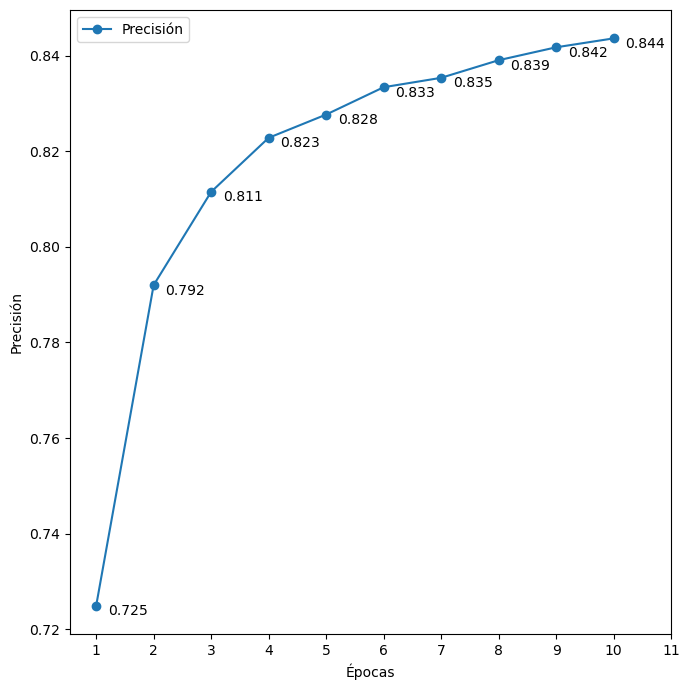

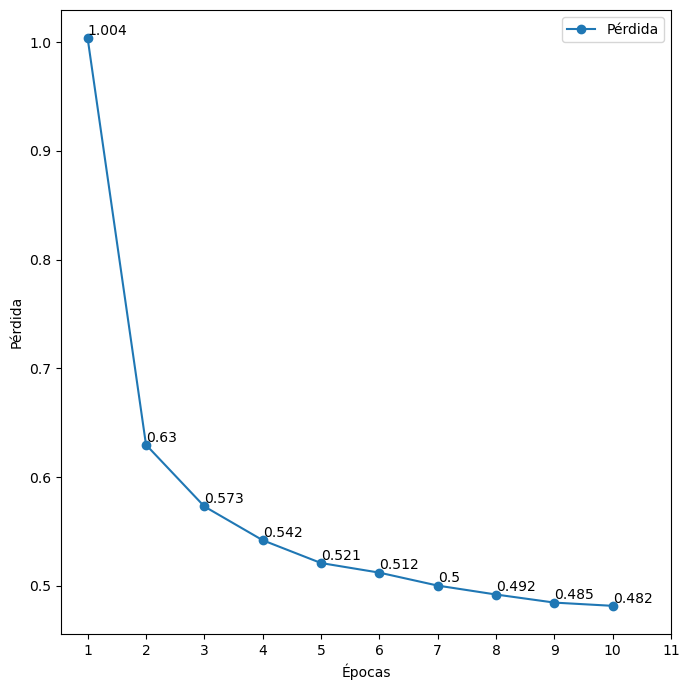

In [189]:
# gráfica del registro de la métrica accuracy durante el entrenamiento
accuracy = historial.history["accuracy"]
epoch = range(1, 11)

fig, ax = plt.subplots(figsize=(7,7))
for i, a in enumerate(accuracy, start=1):
  ax.annotate(round(accuracy[i-1],3), xy=(i+0.2,a-0.002))
ax.plot(epoch, accuracy, "-o", label="Precisión")
ax.set_xlabel("Épocas")
ax.set_ylabel("Precisión")
ax.set_xticks(range(1, 12))
plt.tight_layout()
plt.legend()
plt.show()


# gráfica del registro de la métrica loss durante el entrenamiento
loss = historial.history["loss"]
epochs = range(1,11)

fig, ax = plt.subplots(figsize=(7,7))
for i, l in enumerate(loss, start=1):
  ax.annotate(round(loss[i-1],3), xy=(i,l+0.003))
ax.plot(epochs, loss, "-o", label="Pérdida")
ax.set_xlabel("Épocas")
ax.set_ylabel("Pérdida")
ax.set_xticks(range(1, 12))
plt.tight_layout()
plt.legend()
plt.show()

In [190]:
# evaluación del rendimiento del modelo
score_cnn = model.evaluate(images_test, labels_test_oh)
print(f"El valor de la pérdida es: {score_cnn[0]:.2f}")
print(f"El valor del accuracy es: {score_cnn[1] * 100:.2f}%")

 83/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8649 - loss: 0.4262

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8613 - loss: 0.4345
El valor de la pérdida es: 0.43
El valor del accuracy es: 86.13%


In [191]:
# realizando la prediccion de las primeras 25 imágenes
predict_cnn = model.predict(images_test[0:25, :, :])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [192]:
def graficar_imagen(i, prediccciones_array, etiquetas_reales, imagenes):
    prediccion_array, etiqueta_real, imagen = prediccciones_array[i], etiquetas_reales[i], imagenes[i]
    plt.imshow(imagen[:,:,0], cmap=plt.cm.binary)
    etiqueta_prediccion = np.argmax(prediccion_array)
    etiqueta_real = np.argmax(etiqueta_real)
    if etiqueta_prediccion == etiqueta_real:
      color="blue"
    else:
      color="red"
    plt.xlabel(f"{labels_names[etiqueta_prediccion]}, {np.max(prediccion_array)*100:.2f}%, {labels_names[etiqueta_real]}", color=color)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    

In [193]:
def graficar_barra(i, predicciones_array, etiquetas_reales):
  prediccion_array, etiqueta_real = predicciones_array[i], etiquetas_reales[i]
  grafico = plt.bar(range(10), prediccion_array, color="#777777")
  etiqueta_prediccion = np.argmax(prediccion_array)
  grafico[etiqueta_prediccion].set_color("red")
  etiqueta_real = np.argmax(etiqueta_real)
  grafico[etiqueta_real].set_color("blue")
  plt.xticks(range(10))
  plt.yticks([])
  plt.grid(False)

In [194]:
np.argmax(labels_test[8])

np.int64(0)

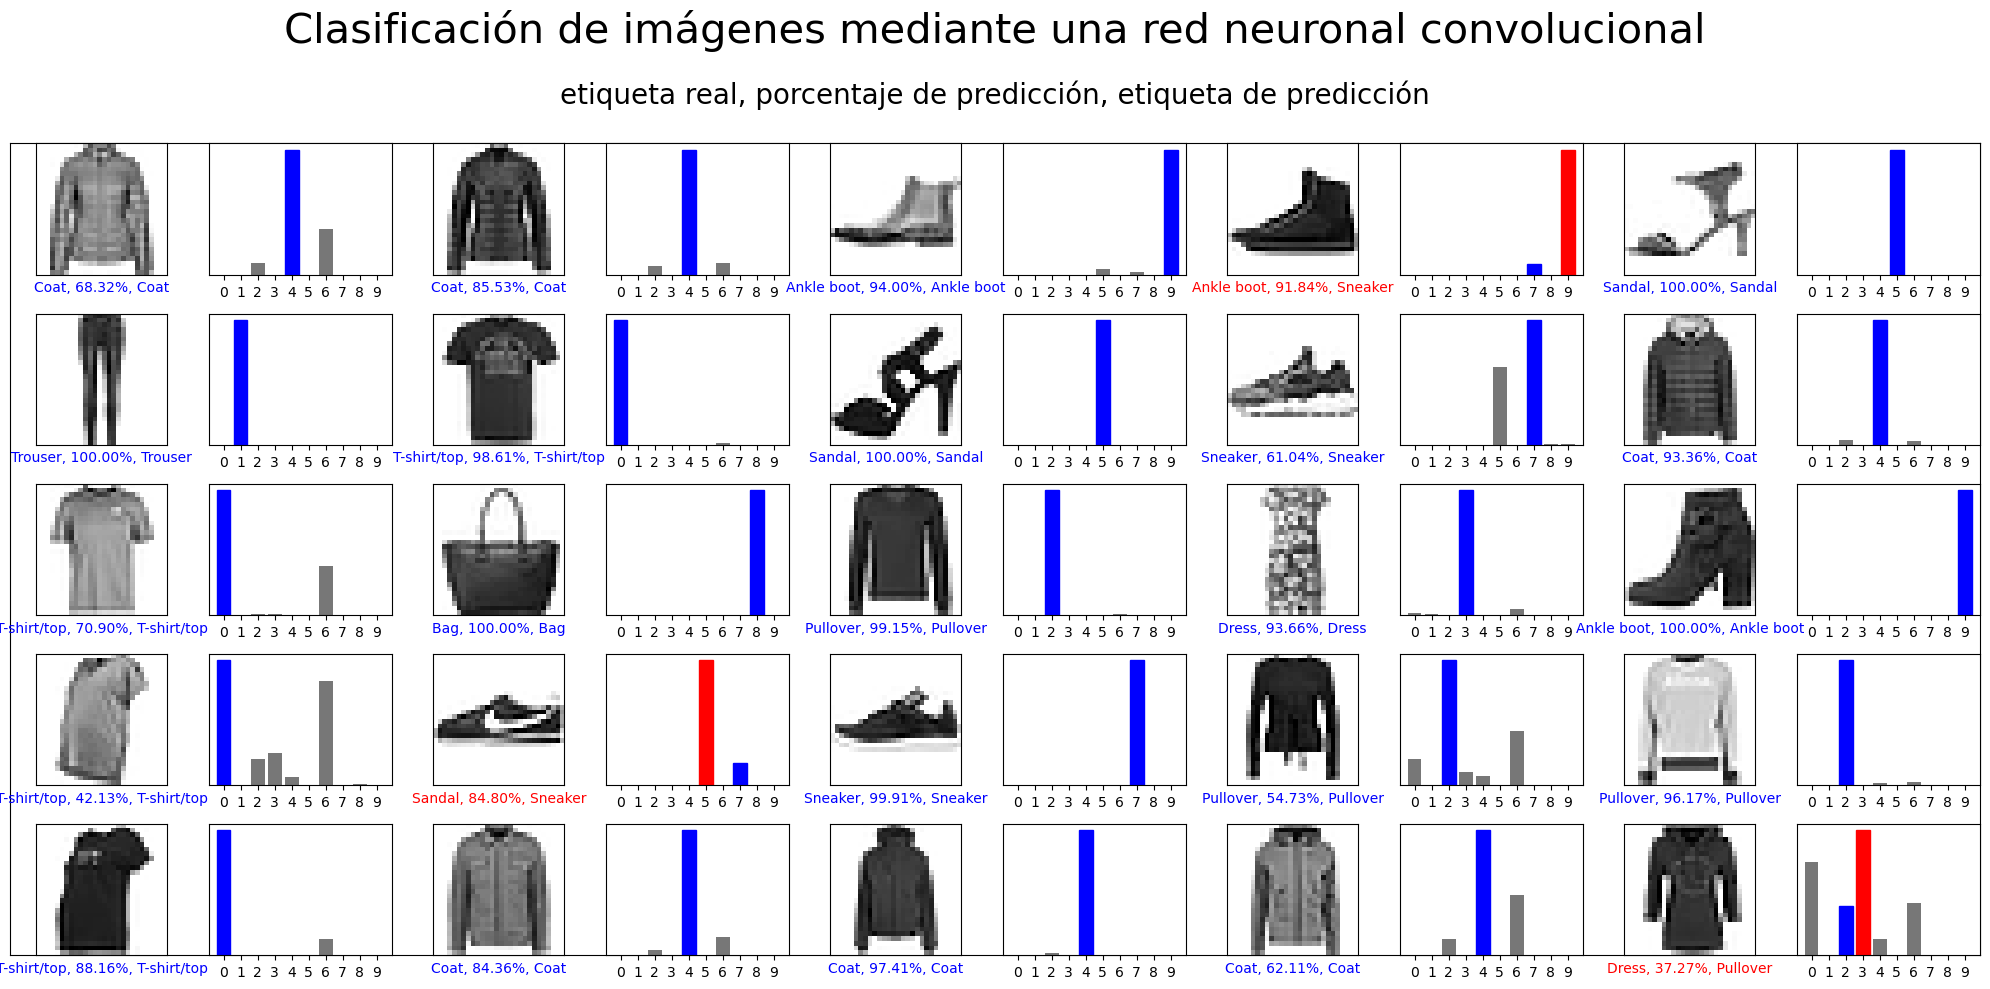

In [195]:
filas = 5
columnas = 5
num_images = filas*columnas

plt.figure(figsize=(2*2*columnas, 2*filas))
plt.title("Clasificación de imágenes mediante una red neuronal convolucional\n\n", size=30)
plt.xticks([])
plt.yticks([])
plt.text(0.5, 1.05, "etiqueta real, porcentaje de predicción, etiqueta de predicción", size=20, ha='center')
for i in range(num_images):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predict_cnn, labels_test_oh, images_test)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_barra(i, predict_cnn, labels_test_oh)
plt.tight_layout()
plt.show()

In [224]:
imagen = images_train[0:5]
# imagen = np.array([imagen])
prediccion = model.predict(imagen)
prediccion.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(5, 10)

In [228]:
for i in range(prediccion.shape[0]):
    print(labels_names[np.argmax(prediccion[i])])

Pullover
Trouser
Bag
Coat
Trouser


## Random Forest

In [196]:
# transformando los datos de las imágenes a una fila única en una matriz 2D
images_train_2D = images_train.reshape(num_train_imgs, -1)
images_test_2D = images_test.reshape(num_test_imgs, -1)

In [197]:
from sklearn.ensemble import RandomForestClassifier
# creando el modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
_ = model_rf.fit(images_train_2D, labels_train)

In [198]:
# realizando la predicción con los datos de validación
predict_rf = model_rf.predict(images_test_2D)

In [199]:
def graficar_imagen_1(i, etiquetas_prediccion, etiquetas_reales, imagenes):
    etiqueta_prediccion, etiqueta_real, imagen = etiquetas_prediccion[i], etiquetas_reales[i], imagenes[i]
    plt.imshow(imagen[:,:,0], cmap=plt.cm.binary)
    if etiqueta_prediccion == etiqueta_real:
        plt.xlabel(f"{labels_names[etiqueta_real]} = {labels_names[etiqueta_prediccion]}", color="blue")
    else:
        plt.xlabel(f"{labels_names[etiqueta_real]} != {labels_names[etiqueta_prediccion]}", color="red")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [200]:
def graficar_barra_1(i, etiquetas_prediccion, etiquetas_reales):
    etiqueta_prediccion, etiqueta_real = etiquetas_prediccion[i], etiquetas_reales[i]
    grafico = plt.bar(range(10), 3, color="#FFFFFF")
    grafico[etiqueta_prediccion].set_color("red")
    grafico[etiqueta_real].set_color("blue")
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)

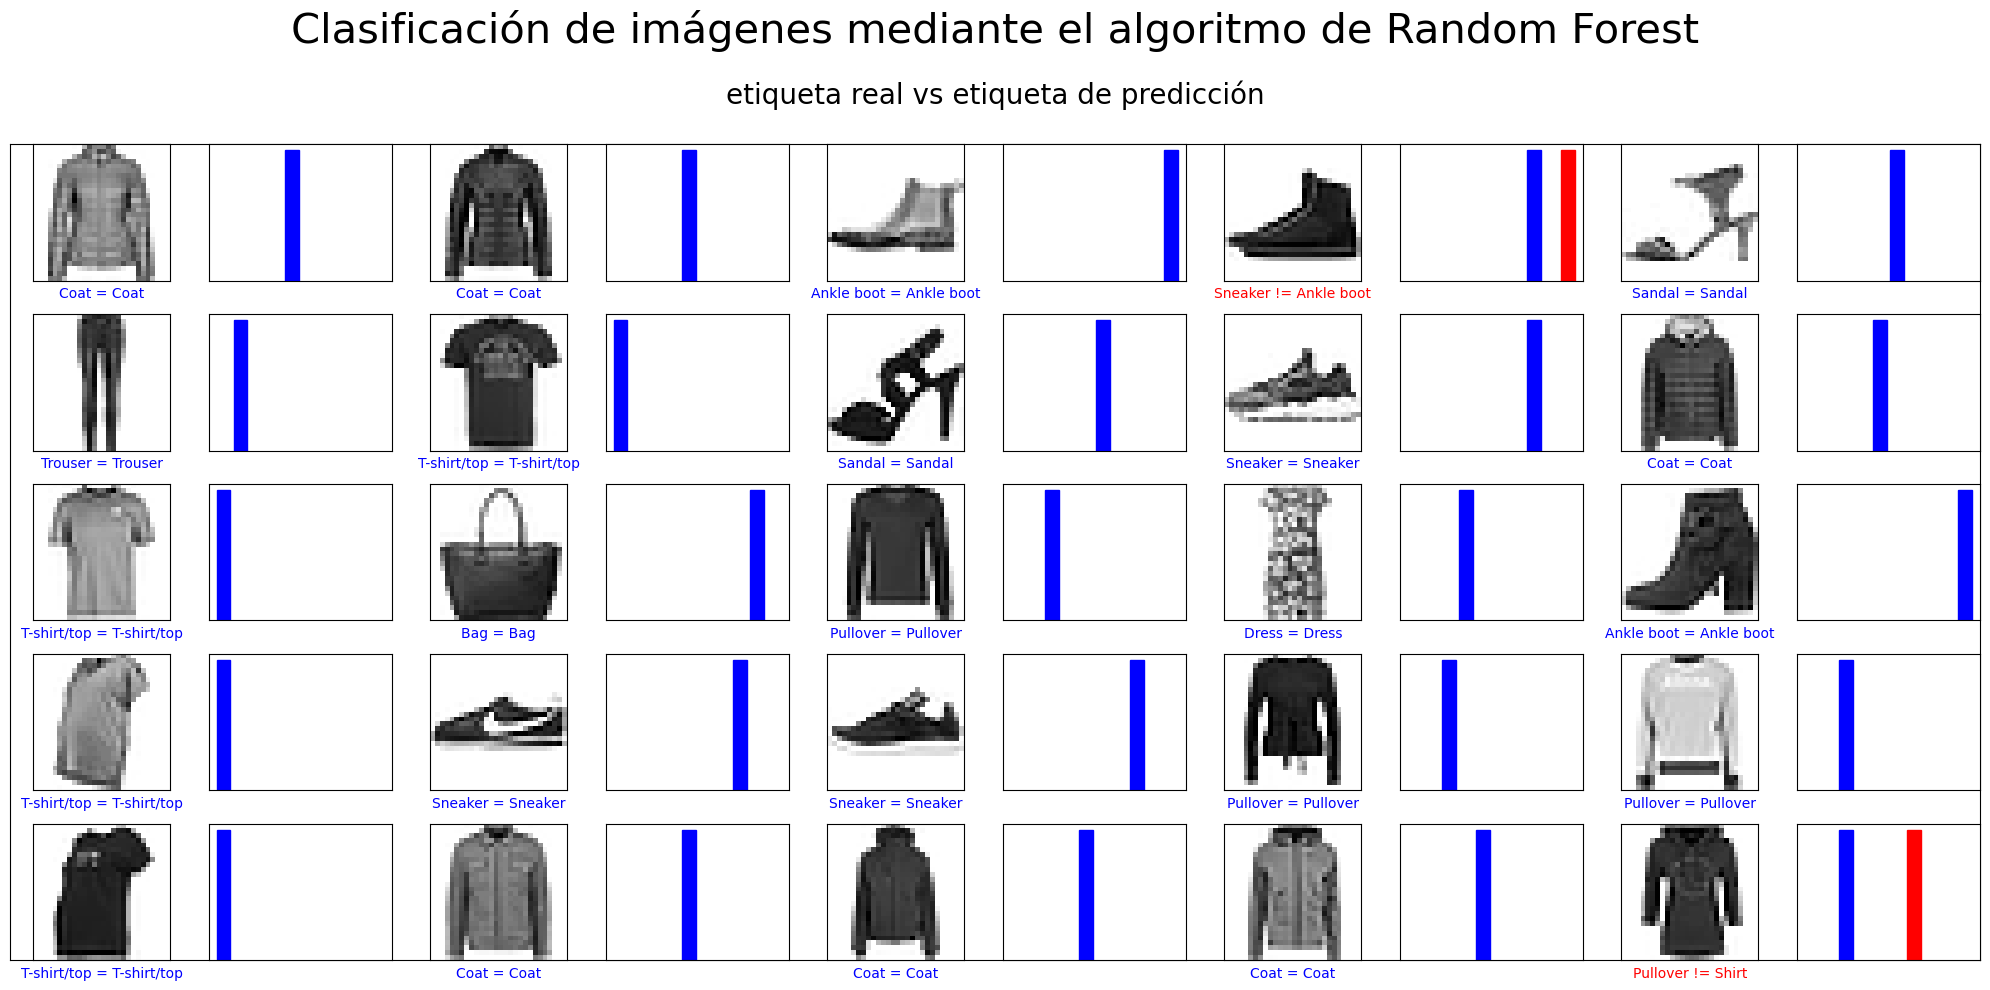

In [201]:
filas = 5
columnas = 5
num_images = filas*columnas

plt.figure(figsize=(2*2*columnas, 2*filas))
plt.title("Clasificación de imágenes mediante el algoritmo de Random Forest\n\n", size=30)
plt.xticks([])
plt.yticks([])
plt.text(0.5, 1.05, "etiqueta real vs etiqueta de predicción", size=20, ha='center')
for i in range(num_images):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen_1(i, predict_rf, labels_test, images_test)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_barra_1(i, predict_rf, labels_test)
plt.tight_layout()
plt.show()

In [202]:
# cálculo de la precisión del modelo de clasificación
from sklearn.metrics import accuracy_score

accuracy_rf = accuracy_score(labels_test, predict_rf)*100
print(f"La precisión del modelo es de {accuracy_rf:.2f}%")

La precisión del modelo es de 87.61%


## Resultados de las métricas

In [203]:
accuracy_cnn = np.round(score_cnn[1] * 100, 2)

full_accuracy = pd.DataFrame({"Accuracy cnn": [accuracy_cnn],
                              "Accuracy rf": [accuracy_rf]})

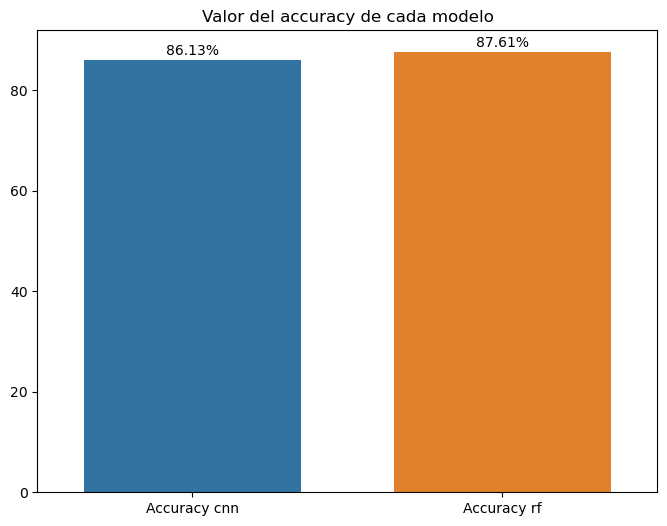

In [204]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(data=full_accuracy, width=0.7)
plt.title("Valor del accuracy de cada modelo")
for e, i in enumerate(full_accuracy.iloc[0,:]):
  plt.annotate(f"{i}%", xy=(full_accuracy.columns[e], i+1), ha="center")
plt.show()